In [1]:
using Plots
using DelimitedFiles
using WindTunnelFlow
using JSON
using Statistics

In [106]:
root_dir = "/u/home/b/beckers/project-sofia/WindTunnelFlow_simulations"
case = "cawt_job_5656804_15_AFUWT_flat_plate_gaussian_suction_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.4"
job_id = "5656804_15"
dir = joinpath(root_dir,case)
cd(dir)

In [107]:
json_file = "$(dir)/AFUWT_gaussian_suction.json"
Q_and_V_probe_file = "$(dir)/$(job_id)_Q_and_V_probe.txt"
force_wind_tunnel_file = "$(dir)/$(job_id)_force_wind_tunnel.txt"
moment_wind_tunnel_file = "$(dir)/$(job_id)_moment_wind_tunnel.txt"

"/u/home/b/beckers/project-sofia/WindTunnelFlow_simulations/cawt_job_5656804_15_AFUWT_flat_plate_gaussian_suction_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.4/5656804_15_moment_wind_tunnel.txt"

In [108]:
function read_vorticity!(w,dir,i)
    files = readdir(dir)
    match_string = "snapshot_$(i).*vorticity_wind_tunnel"
    f_idx = findall(f->occursin(Regex(match_string),f),files)
    println("read_vorticity! => f_idx = $(f_idx)")
    if length(f_idx) == 1
        f = files[f_idx[1]]
        println(f)
        f = joinpath(dir,f)
        w_data = readdlm(f, Float64)
        println("Data size = $(size(w_data)); Recreated grid size = $(size(g))")
        w.data .= w_data
    else
        println("i is out of bounds")
    end
    return w
end

function read_timestamp(dir,i)
    files = readdir(dir)
    match_string = "snapshot_$(i).*time_wind_tunnel"
    f_idx = findall(f->occursin(Regex(match_string),f),files)
    println("read_timestamp => f_idx = $(f_idx)")
    snapshots_time = Float64[]
    f = files[f_idx[1]]
    println(f)
    f = joinpath(dir,f)
    t = readdlm(f, Float64)[1]
    return t
end

function q_criterion!(Q::Nodes{Dual},Ssq::Nodes{Primal},vel_grad,sys)
    Q .= 0.5 .* (vel_grad.dudy .+ vel_grad.dvdx) .^ 2
    grid_interpolate!(Ssq,Q)
    Ssq .+= vel_grad.dudx .^2 .+ vel_grad.dvdy .^2
    Ssq .= .- Ssq # -|S|²
    grid_interpolate!(Q,Ssq)
    Q .+= 0.5 .* (vel_grad.dudy .- vel_grad.dvdx) .^ 2 # |Ω|² - |S|²
    Q .*= 0.5
    Ssq .*= -1
    return Q
end

function q_criterion_normalized!(Q::Nodes{Dual},Ssq::Nodes{Primal},vel_grad,sys)
    q_criterion!(Q,Ssq,vel_grad,sys)
    Q ./= Ssq
    return Q
end

q_criterion_normalized! (generic function with 1 method)

In [109]:
inputs = JSON.parsefile(json_file)
t_suction = inputs["t_suction"]
σ_suction = inputs["sigma_suction"]

force_wind_tunnel = readdlm(force_wind_tunnel_file, '\t', Float64, '\n');
moment_wind_tunnel = readdlm(moment_wind_tunnel_file, '\t', Float64, '\n');
Q_and_V_probe = readdlm(Q_and_V_probe_file, '\t', Float64, '\n');
t = force_wind_tunnel[:,1];
C_D = force_wind_tunnel[:,2];
C_L = force_wind_tunnel[:,3];
C_M = moment_wind_tunnel[:,2];
Q_Q_in = Q_and_V_probe[:,2];
U_mid_hist = Q_and_V_probe[:,4];
V_mid_hist = Q_and_V_probe[:,7];

In [110]:
# Create the wind tunnel problem
include("/u/home/b/beckers/.julia/dev/WindTunnelFlow/examples/AFUWT_create_sys.jl")

wt_walls = create_windtunnel_boundaries(g,params,withinlet=true);

Reading existing grid from 5656804_15_grid.txt:
PhysicalGrid{2}((1512, 448), (756, 224), 0.00625, ((-4.71875, 4.71875), (-1.39375, 1.39375)), 1)
creating flat plate airfoil
creating gaussian gust
Creating WindTunnelProblem... done


In [111]:
t_suction_start = t_suction - 3 * σ_suction
t_suction_end = t_suction + 3 * σ_suction
suction_idxs = findall(t->t_suction_start <= t <= t_suction_end,t)
C_L_max_idx = findmax(C_L[suction_idxs])[2] + suction_idxs[1] - 1
C_L_min_idx = findmin(C_L[suction_idxs])[2] + suction_idxs[1] - 1

frames_times = [
    t_suction_start,
    t[C_L_max_idx],
    t[C_L_min_idx],
    t_suction_end,
    t_suction_end + 1/3 * V_in_star / c_star,
    t_suction_end + 2/3 * V_in_star / c_star]
frames_idx = [findmin(abs.(frames_times[i] .- t))[2] for i in 1:length(frames_times)];

In [112]:
wagner_params = deepcopy(params)
wagner_params["V_SD"] = maximum(V_mid_hist)

0.16901755123274567

In [113]:
# Wagner response
Φ(t) = t ≥ 0 ? 1.0 - 0.165*exp(-0.091*t) - 0.335*exp(-0.6*t) : 0.0

function duhamelintegral(f_array,t_array,ind_fun)
    s = 0.0
    Δt = diff(t_array)
    for i in 2:length(t_array)
        s += f_array[i]*ind_fun(t_array[end]-t_array[i])*Δt[i-1]
    end
    return s
end

duhamelintegral (generic function with 1 method)

In [124]:
ḣ_old = 0.0
Γb_old = 0.0
fx_wagner = Vector()
fy_wagner = Vector()
fy_wagner_added_mass = Vector()
Γ̇b_hist = Vector()
V∞ = [0.0]
V∞_wagner = Vector()

Δt_wagner = 0.01
t_list_wagner = t_suction_start:Δt_wagner:t[end]-1

# Γ_b0 = -π*c_star*V_in_star*α*pi/180
Γ_b0 = 0.0
fy_base = C_L[frames_idx[1]]

for i in 1:length(t_list_wagner)
    suction_velocity!(V∞,nothing,t_list_wagner[i]+Δt_wagner,wagner_params)
    ḣ = V∞[1]
    push!(V∞_wagner,V∞[1])
    ḧ = (ḣ-ḣ_old)/Δt_wagner
    global ḣ_old = ḣ
    Γb = π*c_star*ḣ
    Γ̇b = (Γb-Γb_old)/Δt_wagner
    global Γb_old = Γb

    push!(Γ̇b_hist,Γ̇b)

    fy_wagner_added_mass_i = -π/4*(c_star*cos(α))^2*ḧ + fy_base
    fy_wagner_i = fy_wagner_added_mass_i - Γ_b0 * Φ(t_list_wagner[i]) - duhamelintegral(Γ̇b_hist,t_list_wagner[2:i],Φ)

    push!(fx_wagner,0.0)
    push!(fy_wagner,fy_wagner_i)
    push!(fy_wagner_added_mass,fy_wagner_added_mass_i)
end

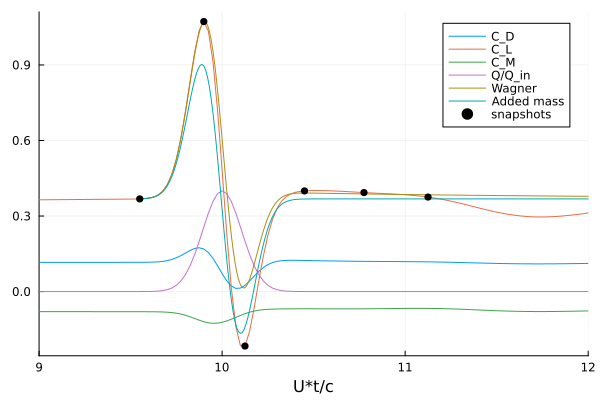

In [125]:
p = plot(t,C_D,label="C_D")
plot!(t,C_L,label="C_L")
plot!(t,C_M,label="C_M")
plot!(t,Q_Q_in,label="Q/Q_in")
plot!(t_list_wagner,fy_wagner,label="Wagner")
plot!(t_list_wagner,fy_wagner_added_mass,label="Added mass")
# vline!(t[frames_idx],c=:black,ls=:dash)
scatter!(t[frames_idx],force_wind_tunnel[frames_idx,3],c=:black,ls=:dash,label="snapshots")
plot!(xlabel="U*t/c",xlim=[9,12])
# savefig("snapshots_forces.pdf")
p

In [118]:
frames_times

6-element Vector{Float64}:
  9.55
  9.9
 10.125
 10.45
 10.783333333333333
 11.116666666666665

In [119]:
fig_xlim = [-0.75,0.75]
fig_ylim = [-0.75,0.75]
# fig_xlim = xlim
# fig_ylim = ylim
y_probe_ψ = range(ylim[1],ylim[2],50)
x_probe_ψ = zeros(length(y_probe_ψ)) .+ 0.0

plot_list = []

v = zeros_grid(sys)
w = zeros_gridcurl(sys)
ψ = zeros_gridcurl(sys)
Q = Nodes(Dual,size(g))
Ssq = Nodes(Primal,size(g))
∇v = EdgeGradient(Primal,Dual,size(g));

read_vorticity!(w,dir,frames_idx[1]);
ViscousFlow.velocity!(v, w, sys, frames_idx[1]);
grad!(∇v,v)
∇v ./= cellsize(sys)
q_criterion!(Q,Ssq,∇v,sys);

n_parallel_points = 30
offset = 0.05
airfoil_pts = length(airfoil)
x_probe_Q = range(airfoil.x[1] + offset * sin(α*pi/180),airfoil.x[end] + offset * sin(α*pi/180),n_parallel_points)
y_probe_Q = range(airfoil.y[1] + offset * cos(α*pi/180),airfoil.y[end] + offset * cos(α*pi/180),n_parallel_points)

Q_fcn = interpolatable_field(Q,g)
Q_probe = Q_fcn.(x_probe_Q,y_probe_Q)
Q_mean = mean(Q_probe)
Q_std = std(Q_probe)
Q_levels = range(Q_mean,Q_mean+3Q_std,10)

println(Q_levels)

for i in frames_idx
    println("i = $(i)")
    read_vorticity!(w,dir,i);
    t_i = read_timestamp(dir,i);
    ViscousFlow.streamfunction!(ψ,w,sys,t_i);

    ψ_fcn = interpolatable_field(ψ,g)
    ψ_probe = ψ_fcn.(x_probe_ψ,y_probe_ψ)

    ViscousFlow.velocity!(v, w, sys, t_i);
    grad!(∇v,v)
    ∇v ./= cellsize(sys)
    q_criterion!(Q,Ssq,∇v,sys);

    p = plot(ψ,g,c=:gray,xlim=fig_xlim,ylim=fig_ylim,levels=ψ_probe,title="time = $(t[i])")
    plot!(w,g,clim=(-15,15),color=cgrad(:RdBu, rev = true),levels=range(-15,15,length=30))
    plot!(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=Q_levels,c=:black)
    plot!(airfoil,fc=:white,lc=:black)
    plot!(wt_walls,c=:black)

    push!(plot_list,p)
end

# gif(anim,fps=10)

read_vorticity! => f_idx = [40]
5656804_15_snapshot_383_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
2.76829331513664:3.6826625880011647:35.91225660714712
i = 383
read_vorticity! => f_idx = [40]
5656804_15_snapshot_383_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
read_timestamp => f_idx = [38]
5656804_15_snapshot_383_time_wind_tunnel.txt
i = 397
read_vorticity! => f_idx = [96]
5656804_15_snapshot_397_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
read_timestamp => f_idx = [94]
5656804_15_snapshot_397_time_wind_tunnel.txt
i = 406
read_vorticity! => f_idx = [132]
5656804_15_snapshot_406_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
read_timestamp => f_idx = [130]
5656804_15_snapshot_406_time_wind_tunnel.txt
i = 419
read_vorticity! => f_idx = [184]
5656804_15_snapshot_419_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated gr

In [120]:
p = plot(plot_list..., layout = (2, 3), size=(800,600))
# savefig("snapshots.pdf")
p

i = 377
read_vorticity! => f_idx = [16]
5656804_15_snapshot_377_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
read_timestamp => f_idx = [14]
5656804_15_snapshot_377_time_wind_tunnel.txt
i = 381
read_vorticity! => f_idx = [32]
5656804_15_snapshot_381_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
read_timestamp => f_idx = [30]
5656804_15_snapshot_381_time_wind_tunnel.txt
i = 385
read_vorticity! => f_idx = [48]
5656804_15_snapshot_385_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
read_timestamp => f_idx = [46]
5656804_15_snapshot_385_time_wind_tunnel.txt
i = 389
read_vorticity! => f_idx = [64]
5656804_15_snapshot_389_vorticity_wind_tunnel.txt
Data size = (1512, 448); Recreated grid size = (1512, 448)
read_timestamp => f_idx = [62]
5656804_15_snapshot_389_time_wind_tunnel.txt
i = 393
read_vorticity! => f_idx = [80]
5656804_15_snapshot_393_vorticity_wind_tunnel.txt
Data size 

[ Info: Saved animation to /u/project/sofia/beckers/WindTunnelFlow_simulations/cawt_job_5656804_15_AFUWT_flat_plate_gaussian_suction_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.4/tmp.gif


Plots.AnimatedGif("/u/project/sofia/beckers/WindTunnelFlow_simulations/cawt_job_5656804_15_AFUWT_flat_plate_gaussian_suction_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.4/tmp.gif")
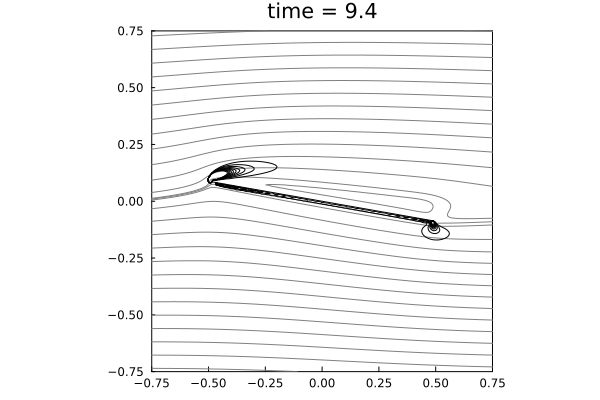

In [121]:
anim_plot_list = []
anim = @animate for i in 377:4:505
    println("i = $(i)")
    read_vorticity!(w,dir,i);
    t_i = read_timestamp(dir,i);
    ViscousFlow.streamfunction!(ψ,w,sys,t_i);

    ψ_fcn = interpolatable_field(ψ,g)
    ψ_probe = ψ_fcn.(x_probe_ψ,y_probe_ψ)

    ViscousFlow.velocity!(v, w, sys, t_i);
    grad!(∇v,v)
    ∇v ./= cellsize(sys)
    q_criterion!(Q,∇v,sys,nodes_primal_tmp);

    p = plot(ψ,g,c=:gray,xlim=fig_xlim,ylim=fig_ylim,levels=ψ_probe,title="time = $(t_i)")
    plot!(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=Q_levels,c=:black)
    plot!(airfoil,fc=:white,lc=:black)
    plot!(wt_walls,c=:black)

    push!(anim_plot_list,p)
end
gif(anim,fps=10)

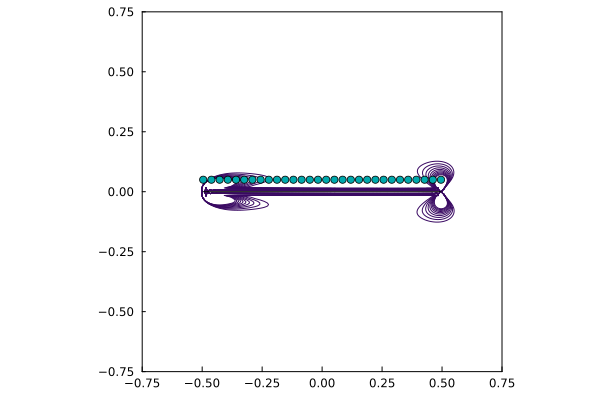

In [16]:
n_parallel_points = 30
offset = 0.05
airfoil_pts = length(airfoil)
x_probe = range(airfoil.x[1] + offset * sin(α*pi/180),airfoil.x[end] + offset * sin(α*pi/180),n_parallel_points)
y_probe = range(airfoil.y[1] + offset * cos(α*pi/180),airfoil.y[end] + offset * cos(α*pi/180),n_parallel_points)

Q_fcn = interpolatable_field(Q,g)
Q_probe = Q_fcn.(x_probe,y_probe)
Q_mean = mean(Q_probe)
Q_std = std(Q_probe)
Q_levels = range(Q_mean,Q_mean+Q_std,10)

# plot(ψ,g,c=:gray,xlim=[-0.75,0.75],ylim=[-0.25,0.25],levels=ψ_probe)
plot(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=Q_levels)
# plot!(w,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75])
plot!(airfoil,fc=:white,lc=:black)
plot!(wt_walls,c=:black)
scatter!(x_probe,y_probe)

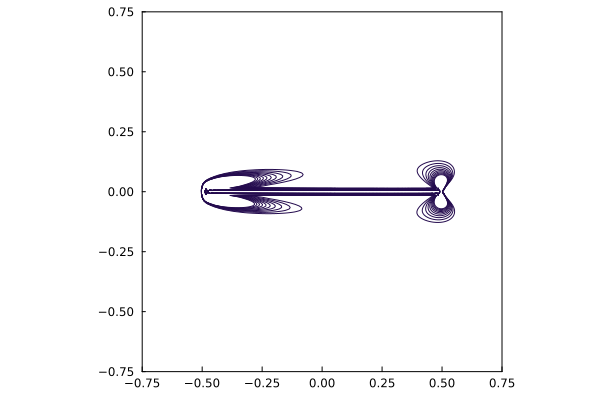

In [17]:
nodes_dual_tmp = Nodes(Dual,size(g))
nodes_primal_tmp = Nodes(Primal,size(g))
Ssq_primal = Nodes(Primal,size(g))
Ssq_dual = Nodes(Dual,size(g))

vel_grad = ∇v

nodes_dual_tmp .= 0.5 .* (vel_grad.dudy .+ vel_grad.dvdx) .^ 2
grid_interpolate!(nodes_primal_tmp,nodes_dual_tmp)
Ssq_primal .= nodes_primal_tmp .+ vel_grad.dudx .+ vel_grad.dvdy
grid_interpolate!(Ssq_dual,Ssq_primal)
Q_verify = 0.5 .* (0.5 .* (vel_grad.dudy - vel_grad.dvdx) .^ 2 .- Ssq_dual)
plot(Q_verify,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=Q_levels)

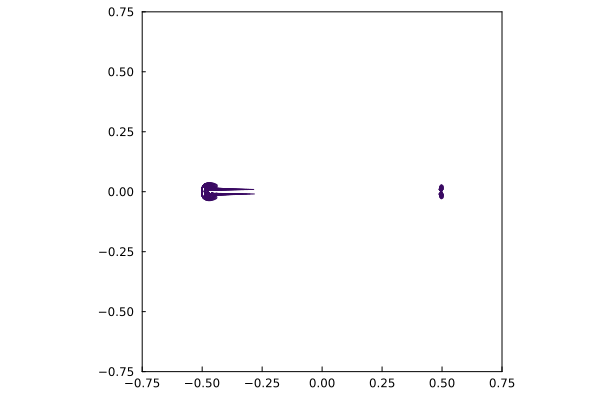

In [18]:
plot(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=range(10,100,100))

In [19]:
# grid_Re_array = [2.5];
# Re_array = [400];
# α_array = [0];
# Q_ratio_array = [0.1];

In [20]:
# force_wt_list = Any[]
# force_no_wt_list = Any[]
# force_wagner_list = Any[]
# label_list = String[]

# task_id = 1
# for grid_Re in grid_Re_array
#     for Re in Re_array
#         for α in α_array
#             for Q_ratio in Q_ratio_array
#                 case_dir = "$(project_sub_dir)_$(job_id)_$(task_id)_$(case)_Grid_Re_$(grid_Re)_Re_$(Re)_aoa_$(α)_Qratio_$(Q_ratio)"
#                 dir = joinpath(root_dir,case_dir)
#                 if isdir(dir)
#                     file_root = joinpath(dir,"$(job_id)_$(task_id)")
#                     force_wt = readdlm("$(file_root)_force_wind_tunnel.txt", '\t', Float64, '\n');
#                     push!(force_wt_list,force_wt)
#                     force_no_wt = readdlm("$(file_root)_force_no_wind_tunnel.txt", '\t', Float64, '\n');
#                     push!(force_no_wt_list,force_no_wt)
#                     force_wagner = readdlm("$(file_root)_force_wagner.txt", '\t', Float64, '\n');
#                     push!(force_wagner_list,force_wagner)
#                     label = "Grid_Re_$(grid_Re)_Re_$(Re)_aoa_$(α)_Qratio_$(Q_ratio)"
#                     push!(label_list,label)
                    
#                 else
#                     println("$(dir) doesn't exist")
#                 end
#                 task_id += 1
#             end
#         end
#     end
# end

In [21]:
# p = plot(xlabel="convective time",ylabel="C_D",ylim=[0,1])
# for task_id in [1]
#     plot!(force_wt_list[task_id][:,1],force_wt_list[task_id][:,2],label=label_list[task_id])
# end
# p

In [22]:
# i_match = 1230
# i_wagner_sxtart = 1230
# i_sim_stop = length(force_wt_list[1][:,1])-10

In [23]:
# # p = plot(xlabel="convective time",ylabel="C_L",ylim=[-0.3,1.1],legend=:topright,size=(400,600),labelfontsize=12,tickfontsize=10,legendfontsize=10)
# p = plot(xlabel="convective time",ylabel="C_L",xlim=[1,4],ylim=[-0.15,0.21],legend=:topright,size=(600,300),labelfontsize=12,tickfontsize=9,legendfontsize=10)
# # for task_id in [1]
# task_id = 1
# #     plot!(force_wt_list[task_id][:,1][1:i_sim_stop],force_wt_list[task_id][:,3][1:i_sim_stop],label="wind tunnel",xlim=[0,12],lw=2)
# #     plot!(force_no_wt_list[task_id][:,1][1:i_sim_stop],force_no_wt_list[task_id][:,3][1:i_sim_stop],label="no wind tunnel",lw=2)
# #     plot!(force_wagner_list[task_id][:,1][i_wagner_start:i_sim_stop],force_wagner_list[task_id][:,3][i_wagner_start:i_sim_stop].-force_wagner_list[task_id][:,3][i_match].+force_wt_list[task_id][:,3][i_match],label="Wagner",lw=2)
#     plot!(force_wt_list[task_id][:,1],force_wt_list[task_id][:,3],label="wind tunnel",lw=1.5)
#     plot!(force_no_wt_list[task_id][:,1],force_no_wt_list[task_id][:,3],label="no wind tunnel",lw=1.5)
#     plot!(force_wagner_list[task_id][:,1],force_wagner_list[task_id][:,3],label="Wagner",lw=1.5)
# # end
# savefig("~/Desktop/DFD22/$(label_list[task_id]).pdf")
# p